In [212]:
import pandas as pd
import numpy as np
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, \
AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor

from sklearn.linear_model import LinearRegression

import category_encoders as ce

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
VAL_SIZE   = 0.20

In [2]:
# функция расчета метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [3]:
train = pd.read_csv('all_auto_ru_09_09_2020.csv')

In [4]:
test = pd.read_csv('test.csv')

In [5]:
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
# удаляем NaN из признака price
train.dropna(subset='price', axis=0, inplace=True)

### Для первичного анализа данных мы будем использовать библиотеку Sweetviz

### Изучим датасет train

In [7]:
# rep = sv.analyze(train, 'price')

In [8]:
# rep.show_notebook()

1. В датасете есть дубликаты ---> удалим их.
2. В датасете содержится 10 категориальных и 11 текстовых признака, и только 5 - числовых.

In [9]:
# ищем дубликаты
duplicates = train[train.duplicated()]
duplicates.head(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
38,Седан,AUDI,0000CC,бензин,1990.0,2.3 MT (133 л.с.),4.0,1992,SEDAN MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,40000.0,2020-09-01T09:56:35Z,NaN,100
170,Седан,AUDI,040001,бензин,1986.0,1.8 AT (90 л.с.),4.0,1990,SEDAN AUTOMATIC 1.8,AUTOMATIC,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,70000.0,2020-09-04T09:42:15Z,NaN,80
351,Седан,AUDI,97948F,бензин,2016.0,1.4 AMT (150 л.с.),4.0,2020,SEDAN ROBOT 1.4,ROBOT,...,LEFT,NaN,NaN,ORIGINAL,True,NaN,1946000.0,2020-08-01T03:19:03Z,NaN,A3


In [10]:
# перепроверили по первому результату списка дубликатов и видим, что действительно в датасете они есть
check_duplicates = train.loc[(train['brand'].isin(['AUDI'])) & (train['color'].isin(['0000CC']))
                            & (train['start_date'] == '2020-09-01T09:56:35Z')]
check_duplicates

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
37,Седан,AUDI,0000CC,бензин,1990.0,2.3 MT (133 л.с.),4.0,1992,SEDAN MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,40000.0,2020-09-01T09:56:35Z,NaN,100
38,Седан,AUDI,0000CC,бензин,1990.0,2.3 MT (133 л.с.),4.0,1992,SEDAN MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,40000.0,2020-09-01T09:56:35Z,NaN,100


In [11]:
# удаляем дубликаты
train.drop_duplicates(keep='first', inplace=True)

#### Рассмотрим все признаки и сделаем вывод о действиях с ними (анализ только на очистку данных).

#### 'price'

1. В целевой переменной содержались пропуски (420), это не критично. Возможно, что владельцы не смогли определить справедливую цену и решили определять ее путем переговоров ---> просто удаляем объекты с пропусками (это было сделано до запуска sweetviz)
2. Видим, что есть аномальное значение = 99.0М ---> проверим. Действительно данная модель имеет такую высокую цену. Однако, мы удалим данное значение, так как такие машины встречаются очень редко. Посмотрим на машины стоимостью больше 20М. 
3. Видим, что в датасете есть 34 машины стоимость свыше 20М и это только Mercedes, в основном G и S classe (признаки brand и model)    ---> эти признаки обязательно должны войти в итоговый датасет.

In [12]:
# удалим модель с ценой в 99M
train.drop(train.loc[train['price'] > 9e+07].index, inplace=True)

In [13]:
# посомтрим на дорогие машины с ценой выше 20М
train.loc[train['price'] > 2e+07].sample(n=5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
86887,Седан,MERCEDES,040001,бензин,2017.0,600 6.0 AT (530 л.с.),4.0,2018,SEDAN AUTOMATIC 600,AUTOMATIC,...,LEFT,NaN,NaN,ORIGINAL,True,NaN,54057400.0,2020-08-17T15:52:18Z,NaN,S_CLASS_MAYBACH
86878,Седан,MERCEDES,040001,бензин,2017.0,650 6.0 AT (630 л.с.),4.0,2018,SEDAN AUTOMATIC 650,AUTOMATIC,...,LEFT,NaN,NaN,ORIGINAL,True,NaN,59087576.0,2019-10-16T18:47:10Z,NaN,S_CLASS_MAYBACH
88160,Купе,MERCEDES,CACECB,бензин,2003.0,5.4 AT (626 л.с.),2.0,2005,COUPE AUTOMATIC 5.4,AUTOMATIC,...,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2008, 'month': 9}",22800000.0,2020-07-13T10:14:41Z,NaN,SLR_KLASSE
83976,Внедорожник 5 дв.,MERCEDES,040001,бензин,2018.0,Brabus 800 4.0 AT (800 л.с.) 4WD,5.0,2020,ALLROAD_5_DOORS AUTOMATIC Brabus,AUTOMATIC,...,LEFT,NaN,NaN,NaN,True,NaN,31600000.0,2020-04-04T15:24:25Z,NaN,G_KLASSE_AMG
83931,Внедорожник 5 дв.,MERCEDES,040001,бензин,2018.0,63 AMG 4.0 AT (585 л.с.) 4WD,5.0,2018,ALLROAD_5_DOORS AUTOMATIC 63,AUTOMATIC,...,LEFT,NaN,1.0,ORIGINAL,True,NaN,21000000.0,2020-08-21T16:03:31Z,NaN,G_KLASSE_AMG


#### 'bodyType'

1. Есть 1 пропуск ---> найдем и удалим.
2. Названия содержат доп информацию по количеству дверей и модели ---> уберем эти лишние данные из признака.

In [14]:
# удаляем NaN из признака bodyType
train.dropna(subset='bodyType', axis=0, inplace=True)

In [15]:
# убираем лишние символы из названий типа кузова
train.bodyType = train.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
train.bodyType.value_counts()

внедорожник      31208
седан            31183
хэтчбек          10718
универсал         3432
лифтбек           3297
минивэн           2363
компактвэн        2065
купе              1285
пикап              602
купе-хардтоп       193
кабриолет          165
родстер            149
фургон             133
микровэн            24
седан-хардтоп       17
тарга                9
лимузин              6
фастбек              3
Name: bodyType, dtype: int64

In [16]:
# заменим названия классов на английские
body_dict = {'седан': 'sedan','внедорожник':'allroad', 'хэтчбек': 'hatchback', 'лифтбек': 'liftback',
             'универсал': 'universal', 'минивэн':'minivan', 'купе': 'cupe', 'компактвэн': 'compactvan',
             'пикап': 'pick-up', 'купе-хардтоп': 'cupe-hardtop', 'родстер': 'roadster', 'фургон': 'wagon',
             'кабриолет': 'cabrio', 'седан-хардтоп': 'sedan-hardtop', 'микровэн': 'microvan', 'лимузин': 'limo',
             'тарга': 'targa', 'фастбек': 'fastback'}
train['bodyType'].replace(body_dict,inplace=True)

#### 'brand'

1. Признак содержит названия марок авто, выделяем 17 наиболее представленных марок, оставшиеся 19 марок (с долей менее 2%) по совокупности занимают 15% предложения. Возможно от них откажемся.

#### 'color'

1. Имеем 16 значений цвета в кодировке HEX (16-значный)---> приведем их к привычным названиям.

In [17]:
dict_color = {'040001': 'чёрный', 'FAFBFB': 'белый', 'CACECB': 'серебристый', '97948F': 'серый', '0000CC': 'синий','EE1D19': 'красный', '200204': 'коричневый',
                '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый',
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}
train['color'].replace(dict_color, inplace=True)

#### 'fuelType'

1. Видим 1 значение "универсал" - очевидно аномальное или ошибочное значение - удалим его. Однако, вохможно мы его уже удалили в результате предыдущих манипуляций.

In [18]:
train.fuelType.unique()

array(['бензин', 'дизель', 'электро', 'гибрид', 'газ'], dtype=object)

#### 'modelDate'

In [19]:
train.modelDate.dtype

dtype('float64')

1. Видим что формат float, хотя очевидно, что это год и формат должен быть целым числом ---> поменяем формат на int64
2. На всякий случай проверим, остались ли в признаке пропуски.
3. также видим,что в датасете есть 1.7% машин модели 2020 года - это новые машины. Наша задача предсказать цен на машины с пробегом. Проверим есть ли хозяева у этих машин и какой пробег. Оказалось, что только 12 машин имют 1 хозяина, то есть являются подержанными. В признаке Владельцы класс NaN говорит о том, что владельцев еще не было = машины новые. Из 12 машин с хозяевами только 5 имеют пробег. 

In [20]:
train.modelDate = train.modelDate.astype('int64')

In [21]:
train.modelDate.isna().sum()

0

In [22]:
modelDate2020 = train[train.modelDate == 2020]

In [23]:
train.groupby([train.modelDate == 2020])['Владельцы'].value_counts(dropna=False)

modelDate  Владельцы
False      3.0          35861
           2.0          20763
           1.0          18218
           NaN          10676
True       NaN           1322
           1.0             12
Name: Владельцы, dtype: int64

In [24]:
train.groupby([train.modelDate == 2020])['mileage'].value_counts(dropna=False)

modelDate  mileage
False      0          10676
           200000      1131
           150000      1031
           180000       889
           160000       854
                      ...  
True       121            1
           1385           1
           2600           1
           3725           1
           4000           1
Name: mileage, Length: 17332, dtype: int64

#### 'name'

1. Это характеристика машины: объем двигателя, тип коробки передач, мощность в лошадиных силах. В некоторых машинах указан тип привода: полный.
2. Возможно стоит выделить каждую характеристику в отдельный признак. Характеристику привода (4WD) не будем выделять так как там будет много пропусков.
3. После разделения мы увидели, что все пропуски в объеме двигателя (engine_nm) относятся к электромобилям ---> заменяем пропуски на 0.

In [25]:
train.name.isna().sum()

0

In [26]:
# в некоторых показателях литража стоит буква d - скорее всего обозначение, что это дизель - избавимся от нее
train.name = train.name.str.replace('d', '')

In [27]:
# выделим литраж мотора
train['engine_nm'] = train['name'].str.extract('([0-9]\.[0-9]+)', expand=False)
train['engine_nm']

0        2.8
1        1.8
2        2.3
3        1.8
4        2.0
        ... 
89373    2.7
89374    2.7
89375    2.0
89376    2.0
89377    2.0
Name: engine_nm, Length: 86852, dtype: object

In [28]:
train['engine_nm'].unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', '2.5', '1.9', '2.1',
       '2.4', '1.6', '1.3', '3.3', '1.4', '1.2', '3.2', '1.5', '3.1',
       '3.0', '2.7', '4.2', '4.0', '3.9', '6.3', '6.0', '3.7', '4.1', nan,
       '3.6', '5.9', '5.2', '2.9', '5.0', '1.7', '4.4', '3.4', '3.5',
       '4.8', '5.4', '6.6', '0.7', '4.9', '4.6', '6.2', '4.5', '6.4',
       '8.2', '5.3', '5.7', '7.0', '1.1', '0.8', '4.3', '8.1', '6.7',
       '3.8', '1.0', '7.5', '7.4', '6.5', '6.1', '6.8', '4.7', '8.4',
       '5.8', '7.3', '5.6', '5.5', '0.0'], dtype=object)

In [29]:
# видим, что есть значение литража = 0.0, смотрим что это такое
train[train['engine_nm'] == '0.0']

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model,engine_nm
83620,allroad,MERCEDES,чёрный,электро,2019,400 Electro AT (300.0 кВт) 4WD,5.0,2020,ALLROAD_5_DOORS AUTOMATIC 400,AUTOMATIC,...,NaN,1.0,ORIGINAL,True,NaN,7600000.0,2020-07-07T13:34:32Z,NaN,EQC,0.0
83621,allroad,MERCEDES,чёрный,электро,2019,400 Electro AT (300.0 кВт) 4WD,5.0,2020,ALLROAD_5_DOORS AUTOMATIC 400,AUTOMATIC,...,NaN,1.0,ORIGINAL,True,"{'year': 2020, 'month': 7}",8076322.0,2020-07-19T14:55:05Z,NaN,EQC,0.0


---> Это электрокары, у которых нет объема двигателя! Проверим значения NaN для признака engine_nm

In [30]:
train['engine_nm'].isna().sum()

107

In [31]:
# мы видим, что все пропуски в engine_nm относятся к электромобилям!
g = train.groupby('fuelType')
g.count().rsub(g.size(), axis=0)

,bodyType,brand,color,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,...,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model,engine_nm
fuelType,,,,,,,,,,,,,,,,,,,,,
бензин,0,0,0,0,0,0,0,0,0,0,...,73022,8749,206,0,48551,0,0,73022,0,0
газ,0,0,0,0,0,0,0,0,0,0,...,11,0,0,0,4,0,0,11,0,0
гибрид,0,0,0,0,0,0,0,0,0,0,...,289,6,2,0,155,0,0,289,0,0
дизель,0,0,0,0,0,0,0,0,0,0,...,13421,3198,146,0,9232,0,0,13421,0,0
электро,0,0,0,0,0,0,0,0,0,0,...,109,45,3,0,72,0,0,109,0,107


In [32]:
# заменяем пропуски на 0
train.engine_nm.fillna(0, inplace=True)

In [33]:
# переводим в числовой формат данных
train['engine_nm'] = pd.to_numeric(train['engine_nm'])

In [34]:
# вытаскивам параметр трансмиссии
train['transmission_nm'] = train['name'].str.extract('([a-zA-Z]+)', expand=False)
train['transmission_nm']

0        MT
1        MT
2        MT
3        MT
4        MT
         ..
89373    AT
89374    AT
89375    AT
89376    AT
89377    AT
Name: transmission_nm, Length: 86852, dtype: object

In [35]:
train['horse_power_nm'] = train.name.str.split('(').str[1].str.extract('(\d+)').astype('int64')
train['horse_power_nm'][2647]

372

In [36]:
train['horse_power_nm'].isna().sum()

0

In [37]:
train['horse_power_nm'].describe()

count    86852.000000
mean       170.799417
std         83.467230
min          9.000000
25%        115.000000
50%        150.000000
75%        199.000000
max        800.000000
Name: horse_power_nm, dtype: float64

In [38]:
# теперь можем удалить признак name
train.drop('name', axis=1, inplace=True)

#### 'numberOfDoors'

1. Проверим пропуски
2. Видим, что есть значение с 0 дверей, проверим его.

In [39]:
train.numberOfDoors.isna().sum()

0

In [40]:
train[train.numberOfDoors == 0]

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,...,ПТС,Таможня,Владение,price,start_date,hidden,model,engine_nm,transmission_nm,horse_power_nm
88065,cabrio,MERCEDES,белый,бензин,1904,0.0,1904,CABRIO MECHANICAL 5.3,MECHANICAL,5.3,...,ORIGINAL,True,"{'year': 2014, 'month': 2}",12000000.0,2019-11-20T14:14:11Z,NaN,SIMPLEX,5.3,MT,32


In [41]:
# заменяем количество дверей 0 на 2, так как это кабриолет
train.numberOfDoors[train['numberOfDoors']==0] = 2

In [42]:
# переводим в целочисленный формат
train['numberOfDoors'] = train['numberOfDoors'].astype('int64')

#### 'productionDate'

In [43]:
train.productionDate.dtype

dtype('int64')

1. Видим, что примерно 15% машин было произведено в 2020 году. Ранее мы определили, что скорее большинство из них - это новые авто, которые продаются впервые. 

In [44]:
train.groupby('productionDate')['price'].median()

productionDate
1904    12000000.0
1923     3800000.0
1924     3000000.0
1927     3600000.0
1931     4703812.0
           ...    
2016     1250000.0
2017     1349000.0
2018     1627000.0
2019     2603800.0
2020     2853810.0
Name: price, Length: 80, dtype: float64

#### 'vehicleConfiguration'

1. Видим, что это данные с характеристиками авто: тип кузова, количество дверей, тип трансмиссии, объем двигателя. Эти данные у нас уже есть в отдельных признаках
2. Можно попробовать его оставить как пример текстового признака, и посмотреть как поведет себя модель при его обработке.

In [45]:
train['vehicleConfiguration'].isna().sum()

0

#### 'vehicleTransmission'

1. Данные о типе трансмиссии - видим, что у нас есть 4 типа.
2. Ранее мы извлекали из признака name типы трансфмиссии. Попробуем сравнить эти два признака.
3. При ближайшем рассмотрении классов признака, получившегося их name, мы видим, что помимо типа трансмиссии там содержатся иные характеристики авто, типа: 'TFSI', 'TDI' - это типы двигателя; 'Competition', 'Aircross' - комплектации, 'Stingray', 'Carrera' - модели, 'Brabus', 'Pullman' - тюнинговые ателье, и так далее ---> признак transmission_nm мы удалим. 

In [46]:
train.vehicleTransmission.isna().sum()

0

In [47]:
train.vehicleTransmission.value_counts()

AUTOMATIC     47774
MECHANICAL    24971
ROBOT          7516
VARIATOR       6591
Name: vehicleTransmission, dtype: int64

In [48]:
print(train.transmission_nm.unique())

['MT' 'AT' 'S' 'AMT' 'ultra' 'CVT' 'V' 'tiptronic' 'TDI' 'TFSI'
 'Tiptronic' 'Long' 'Electro' 'clean' 'hyb' 'M' 'i' 'xDrive' 'xi'
 'Ecotronic' 'N' 'Li' 'x' 'L' 'Active' 'Ah' 'Competition' 'sDrive' 's'
 'si' 'is' 'e' 'ActiveHybri' 'ESV' 'spee' 'SS' 'ZL' 'Stingray' 'Z'
 'Double' 'EV' 'EXT' 'SRT' 'Fifth' 'SWB' 'Gran' 'oors' 'SensoDrive'
 'Aircross' 'Triomphe' 'Hyractive' 'CrossTourer' 'XL' 'Best' 'R' 'Hellcat'
 'Crew' 'Sport' 'Raptor' 'SVT' 'KAT' 'Electric' 'ST' 'StreetKa'
 'PowerShift' 'Shelby' 'SHO' 'LWB' 'Type' 'Hybri' 'Shuttle' 'el' 'Spike'
 'Spaa' 'Prime' 'Limousine' 'Classic' 'EX' 'FX' 'G' 'I' 'JX' 'Q' 'SVR'
 'TrailHawk' 'Trackhawk' 'Trailhawk' 'GT' 'X' 'h' 't' 'C' 'Brawny' 'Har'
 'Soft' 'John' 'Cooper' 'One' 'Granis' 'CZ' 'Plus' 'VR' 'Easy' 'Super'
 'Ceia' 'PHEV' 'Cubic' 'kWh' 'Joy' 'series' 'Latio' 'GTC' 'LZ' 'CNG' 'GSi'
 'Country' 'Seats' 'Carrera' 'Turbo' 'GTS' 'RS' 'Diesel' 'E' 'Europa'
 'Campus' 'Be' 'Stepway' 'RX' 'Conquest' 'Scout' 'DSG' 'ACT' 'tS' 'STi'
 'XV' 'US' 'Japan' '

In [49]:
train.drop(['transmission_nm'], axis=1, inplace=True)

#### 'engineDisplacement'

1. Это признак, показывающий объем двигателя машины.
2. Изучив признак, мы видим, что там помимо объема двигателя содержится много "шума": '6-speed' - тип трансмиссии, 'Stingray' - модель, 'Alltrack' - тип привода, и так далее. Попробуем выделить только литраж по шаблону число-точка-число.
3. Оставляем созданный нами признак endine_nm, остальные удаляем.

In [50]:
train.engineDisplacement.isna().sum()

0

In [51]:
train.engineDisplacement.unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d', '2.5d',
       '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3', '1.4',
       '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '3.0d', '2.7d',
       '16V', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0', '60', '3.9d', '6.0',
       '3.7', '4.1d', '35', '8tiptronic', 'clean', '2.0hyb', '3.6',
       '5.9d', 'V10', 'V8', '2.5', '2.9', '5.0', '5.2', 'M135i', '116i',
       '120i', '118i', '135i', 'M140i', '125i', '120d', '130i', '118d',
       '218i', '220i', '220d', 'M235i', '218d', '216d', '335i', '320i',
       '318i', '318d', '320d', '316i', '328i', '330i', '325xi', '325i',
       '330d', '340i', '323i', '335d', '335xi', '330xi', '316', '315',
       '318', 'N46', '420d', '428i', '420i', '435i', '430i', '440i',
       '520d', '530d', '525i', '523i', '520i', '530i', '525d', '528i',
       '550i', '535d', 'M550i', 'M550d', '540i', '535i', '530xi', '5

In [52]:
# выделим только литраж мотора по шаблону число-точка-число
train['engine_displ_litres'] = train['engineDisplacement'].str.extract('([0-9]\.[0-9]+)', expand=False)
train['engine_displ_litres'].unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', nan, '2.5', '1.9', '2.1',
       '2.4', '1.6', '1.3', '3.3', '1.4', '1.2', '3.2', '1.5', '3.1',
       '3.0', '2.7', '4.2', '4.0', '3.9', '6.0', '3.7', '4.1', '3.6',
       '5.9', '2.9', '5.0', '5.2', '0.7', '4.4', '4.9', '4.8', '4.6',
       '6.2', '4.5', '6.4', '8.2', '5.3', '5.7', '7.0', '1.1', '0.8',
       '3.4', '4.3', '8.1', '5.4', '3.8', '1.7', '6.6', '1.0', '7.5',
       '7.4', '6.5', '3.5', '6.8', '4.7', '6.7', '5.8', '7.3', '5.6'],
      dtype=object)

In [53]:
# сразу получили 20000+ пропусков - это очень много!
train['engine_displ_litres'].isna().sum()

20296

In [54]:
train.engine_nm.describe()

count    86852.000000
mean         2.204532
std          0.886019
min          0.000000
25%          1.600000
50%          2.000000
75%          2.500000
max          8.400000
Name: engine_nm, dtype: float64

In [55]:
train['engineDisplacement'] = train['engine_nm']

In [56]:
train.engineDisplacement.describe()

count    86852.000000
mean         2.204532
std          0.886019
min          0.000000
25%          1.600000
50%          2.000000
75%          2.500000
max          8.400000
Name: engineDisplacement, dtype: float64

In [57]:
# удалим признаки engineDisplacement и engine_displ_litres
train.drop(['engine_nm', 'engine_displ_litres'], axis=1, inplace=True)

#### 'enginePower'

1. У нас есть признак, изначально данный в датасете (enginePower) и признак. который мы выделили из признака name. Мы выяснили, что расхождения между ними есть но минимальны.
2. Давайте оставим оригинальный признак, а созданный нами - удалим.

In [58]:
train.enginePower.nunique()

395

In [59]:
train.horse_power_nm.nunique()

396

In [60]:
# расхождения в данных двух признаков в 109 объектах
compare_column = np.where(train['enginePower'] == train['horse_power_nm'], True, False)
train["power_equal"] = compare_column
train["power_equal"].value_counts()

True     86743
False      109
Name: power_equal, dtype: int64

In [61]:
train.enginePower.isna().sum()

0

In [62]:
train.horse_power_nm.isna().sum()

0

In [63]:
train.drop('horse_power_nm', axis=1, inplace=True)

In [64]:
# удалим вспомогательный признак power_equal
train.drop('power_equal', axis=1, inplace=True)

In [65]:
# переводим в целочисленный формат
train['enginePower'] = train['enginePower'].astype('int64')

In [66]:
train.enginePower.describe()

count    86852.000000
mean       170.882755
std         83.605772
min         11.000000
25%        115.000000
50%        150.000000
75%        199.000000
max        800.000000
Name: enginePower, dtype: float64

#### 'description'

1. Видим, что это текстовый признак.
2. Практически все значения уникальны.
3. Содержание тектовых значений - рекламная информация от продавцов и содержит минимум информации о самих авто и их параметрах ---> на удаление.

In [67]:
train.drop('description', axis=1, inplace=True)

#### 'mileage'

1. Есть пропуски, надо проверить связь с пробегом и владельцем - есть гипотеза, что это новые машины.
2. Также есть машины с пробегом = 0, проверим на год выпуска, гипотеза, что авто новые.
---> похоже, что машины 2020 даты выпуска не имеют хозяев и у них нулевой пробег - они новые.
---> также есть машины 2017-2019 годов выпуска, у которых также нет хозяина.

3. Пока оставим признак и посомтрим на остальные.

In [68]:
# смотрим связь признака с нулевым пробегом с количеством владельцев и годом выпуска
train.groupby([train.mileage == 0])['productionDate', 'Владельцы', 'ПТС'].value_counts(dropna=False)

mileage  productionDate  Владельцы  ПТС     
False    2008            3.0        ORIGINAL    3245
         2007            3.0        ORIGINAL    2695
         2012            2.0        ORIGINAL    2425
         2011            3.0        ORIGINAL    2180
         2013            2.0        ORIGINAL    2132
                                                ... 
True     2020            NaN        NaN          315
         2018            NaN        ORIGINAL      79
         2019            NaN        NaN           39
         2018            NaN        NaN            3
         2017            NaN        ORIGINAL       1
Length: 318, dtype: int64

#### 'Комплектация'

1. Полезный признак, в котором содержатся характиристики комплектации авто. Несмотря на то, что некоторые характеристики мы уже видели в других признаках, оттуда можно было бы извлечь информацию.
2. Однако, мы видим, что в 66% записей стоит 'id: 0', то есть фактически это пропуск, который нам нечем заполнить.
3. Принимаем решение - к сожалению, удаляем признак.

In [69]:
train.drop('Комплектация', axis=1, inplace=True)

#### 'Привод'

1. Видим признак, состоящий из 3-х классов.

In [70]:
train['Привод'].isna().sum()

0

#### 'Руль'

1. Признак с 2-мя классами и очень сильным дисбалансом (98/2, %), но так как это не целовой признак, то оставляем все как есть.

In [71]:
train['Руль'].isna().sum()

0

#### 'Состояние'

1. Видим, что это признак со 100% пропуском ---> на удаление.

In [72]:
train.drop('Состояние', axis=1, inplace=True)

#### 'ПТС'

1. Видим признак из 2-х классов и определенным количеством пропусков. Разберемся, чем их заменить. 
2. Гипотеза: пропуск означает, что ПТС еще не выпускался - характерно для новых машин.
3. Мы выяснили, что большинство в пропусках в признаке относится к машинам 2019-2020 гг выпуска, но есть несколько пропусков и в более ранних годах. 
4. Видим, что есть 3 дорогие машины выпуска 2018 года, у которых нет владельцев и пробега ---> вероятно это также ни разу не проданные машины. 
5. Так как новые машины нас не интересуют, то мы просто удалим объекты с этими пропусками.

<AxesSubplot:>

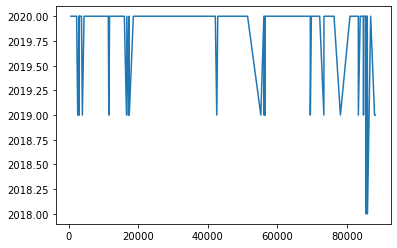

In [73]:
train.loc[train['ПТС'].isna()]['productionDate'].plot()

In [74]:
train.loc[train['ПТС'].isna()][train['productionDate'] < 2019]

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,...,Привод,Руль,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
85457,allroad,MERCEDES,чёрный,бензин,2018,5,2018,ALLROAD_5_DOORS AUTOMATIC 450,AUTOMATIC,3.0,...,полный,LEFT,NaN,NaN,True,NaN,6136000.0,2020-07-31T13:59:40Z,NaN,GLE_KLASSE
85460,allroad,MERCEDES,чёрный,бензин,2018,5,2018,ALLROAD_5_DOORS AUTOMATIC 450,AUTOMATIC,3.0,...,полный,LEFT,NaN,NaN,True,NaN,6299000.0,2020-07-31T14:01:41Z,NaN,GLE_KLASSE
85926,allroad,MERCEDES,белый,бензин,2015,5,2018,ALLROAD_5_DOORS AUTOMATIC 63,AUTOMATIC,5.5,...,полный,LEFT,NaN,NaN,True,NaN,7850000.0,2020-07-31T14:54:37Z,NaN,GLE_KLASSE_COUPE_AMG


In [75]:
# удаляем NaN из признака bodyType
train.dropna(subset='ПТС', axis=0, inplace=True)

In [76]:
train['ПТС'].isna().sum()

0

#### 'Владельцы'

1. Признак из 3-х классов, а также много пропусков. Пробуем разобраться.
2. Гипотеза: пропуски - это машины, у которых не было владельца, то есть значение класса = 0.

In [77]:
train.groupby('Владельцы', dropna=False)['productionDate', 'mileage'].mean()

,productionDate,mileage
Владельцы,,
1.0,2013.730060,101856.325288
2.0,2010.393826,146584.418100
3.0,2006.198405,195706.093528
NaN,2019.898376,0.000000


3. Мы видим, что в основном пропуски соответствуют машинам 2019-20 гг выпуска и без пробега. Введем новый класс = 0 (владельцев не было в принципе) для заполнения пропусков по этим условиям. 

In [78]:
train['Владельцы'].isna().sum()

11641

In [79]:
# заполнили пропуск на 0 при услвовии, что год выпуска 2020
train.loc[(train.productionDate >= 2019) & (train.mileage == 0), 
          'Владельцы'] = train['Владельцы'].fillna(0)

In [80]:
train['Владельцы'].isna().sum()

80

4. Оказалось, что есть машины с 0-м пробегом и моложе 2019 года выпуска включительно.

In [81]:
train.groupby('Владельцы', dropna=False)['productionDate', 'mileage'].median()

,productionDate,mileage
Владельцы,,
0.0,2020.0,0.0
1.0,2014.0,88411.0
2.0,2011.0,135500.0
3.0,2007.0,180000.0
NaN,2018.0,0.0


In [82]:
train.loc[train['Владельцы'].isna()][train['productionDate'] < 2019].sample(n=5)

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,...,Привод,Руль,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
85226,allroad,MERCEDES,чёрный,бензин,2018,5,2018,ALLROAD_5_DOORS AUTOMATIC 450,AUTOMATIC,3.0,...,полный,LEFT,NaN,ORIGINAL,True,NaN,6511070.0,2020-07-30T10:32:44Z,NaN,GLE_KLASSE
85195,allroad,MERCEDES,синий,бензин,2018,5,2018,ALLROAD_5_DOORS AUTOMATIC 450,AUTOMATIC,3.0,...,полный,LEFT,NaN,ORIGINAL,True,NaN,6570070.0,2020-07-30T10:32:44Z,NaN,GLE_KLASSE
85435,allroad,MERCEDES,синий,бензин,2018,5,2018,ALLROAD_5_DOORS AUTOMATIC 450,AUTOMATIC,3.0,...,полный,LEFT,NaN,ORIGINAL,True,NaN,6570070.0,2020-07-30T10:29:52Z,NaN,GLE_KLASSE
12305,allroad,CHERY,синий,бензин,2014,5,2018,ALLROAD_5_DOORS VARIATOR 1.6,VARIATOR,1.6,...,передний,LEFT,NaN,ORIGINAL,True,NaN,899900.0,2018-12-30T23:25:54Z,NaN,TIGGO_3
85143,allroad,MERCEDES,серый,бензин,2018,5,2018,ALLROAD_5_DOORS AUTOMATIC 450,AUTOMATIC,3.0,...,полный,LEFT,NaN,ORIGINAL,True,NaN,6951632.0,2020-08-21T00:27:21Z,NaN,GLE_KLASSE


5. Видим, что остались машины 2018 года выпуска и с 0-м пробегом. С большой долей вероятности можем предположить, что и это новые машины, которые никогда не были проданы. Заменим значения признака на 0.

In [83]:
train.loc[(train.productionDate == 2018) & (train.mileage == 0), 
          'Владельцы'] = train['Владельцы'].fillna(0)

In [84]:
train.loc[train['Владельцы'].isna()]

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,...,Привод,Руль,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
35008,sedan,KIA,серый,бензин,2015,4,2017,SEDAN AUTOMATIC 5.0,AUTOMATIC,5.0,...,задний,LEFT,NaN,ORIGINAL,True,NaN,3829900.0,2018-03-16T10:33:04Z,NaN,QUORIS


6. Видим, что осталась 1 машина произведенная в 2017 году, без владельца и с 0-м пробегом. Мало вероятно, что за 3 года машину ни разу не продали ---> удалим этот объект как аномальный.

In [85]:
train.dropna(subset='Владельцы', axis=0, inplace=True)

In [86]:
train['Владельцы'].isna().sum()

0

In [87]:
# переводим в целочисленный формат
train['Владельцы'] = train['Владельцы'].astype('int64')

#### 'mileage' update

1. Вернемся к признаку mileage

In [88]:
train.mileage.describe()

count      86494.000000
mean      137796.717726
std       102219.519555
min            0.000000
25%        63000.000000
50%       132000.000000
75%       196000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [89]:
train.mileage.isna().sum()

0

In [90]:
train[train.mileage == 0].count()

bodyType                11640
brand                   11640
color                   11640
fuelType                11640
modelDate               11640
numberOfDoors           11640
productionDate          11640
vehicleConfiguration    11640
vehicleTransmission     11640
engineDisplacement      11640
enginePower             11640
mileage                 11640
Привод                  11640
Руль                    11640
Владельцы               11640
ПТС                     11640
Таможня                 11640
Владение                    0
price                   11640
start_date              11640
hidden                      0
model                   11640
dtype: int64

In [91]:
train[train.mileage > 700000].count()

bodyType                53
brand                   53
color                   53
fuelType                53
modelDate               53
numberOfDoors           53
productionDate          53
vehicleConfiguration    53
vehicleTransmission     53
engineDisplacement      53
enginePower             53
mileage                 53
Привод                  53
Руль                    53
Владельцы               53
ПТС                     53
Таможня                 53
Владение                19
price                   53
start_date              53
hidden                   0
model                   53
dtype: int64

2. Мы видим: объекты с 0-м пробегом = 11640 и объекты с аномально высоким пробегом (> 700 000 км).
3. По условию соревнования мы рассматриваем только автомобили с пробегом ---> удаляем авто без пробега, так как предыдущий анализ показал, что скорее всего это новые авто ни разу не проданные.

In [92]:
# удаляем строки с 0-м пробегом
train.drop(train[train.mileage == 0].index, inplace=True)

#### 'Таможня'

1. У данного признака только 1 уникальное значение ---> удалим его как неинформативный признак.

In [93]:
train.drop('Таможня', axis=1, inplace=True)

#### 'Владение'

1. Мы могли бы получить период владения авто, так как имеем дату начала владения и дату, когда был сделан парсинг (09-09-2020), что дало бы нам довольно интересный признак.
2. Но так как мы видим большое количество пропусков (67%), которые анм нечем заполнить достоверно, то мы вынуждены просто удалить его.

In [94]:
train.drop('Владение', axis=1, inplace=True)

#### 'start_date'

1. Время начала загрузки данных с сайта ---> неинформативный признак, на удаление.

In [95]:
train.drop('start_date', axis=1, inplace=True)

#### 'hidden'

1. Признак имеет 100% пропусков ---> на удаление.

In [96]:
train.drop('hidden', axis=1, inplace=True)

#### 'model' 

1. Названия моделей, больше 1000 уникальных значений, TOP 10 моделей кажда я долей в 2%.

In [97]:
train.model.sample(n=5)

45963    SPACE_STAR
39994          3MPS
70273          GOLF
71632        PASSAT
76639           960
Name: model, dtype: object

In [98]:
# переименуем название признака для соответствия названию в тестовом датасете
train.rename(columns={'model': 'modelName'}, inplace=True)

#### Итог по train

In [99]:
# добавим признак sell_id
train['sell_id'] = 0

In [100]:
train.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'vehicleTransmission',
       'engineDisplacement', 'enginePower', 'mileage', 'Привод', 'Руль',
       'Владельцы', 'ПТС', 'price', 'modelName', 'sell_id'],
      dtype='object')

In [101]:
train = train[['sell_id', 'bodyType', 'brand', 'modelName', 'color', 'fuelType', 
               'modelDate', 'productionDate', 'mileage', 'engineDisplacement', 
               'enginePower', 'numberOfDoors', 'vehicleTransmission', 
               'vehicleConfiguration', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'price']]

In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74854 entries, 0 to 89377
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sell_id               74854 non-null  int64  
 1   bodyType              74854 non-null  object 
 2   brand                 74854 non-null  object 
 3   modelName             74854 non-null  object 
 4   color                 74854 non-null  object 
 5   fuelType              74854 non-null  object 
 6   modelDate             74854 non-null  int64  
 7   productionDate        74854 non-null  int64  
 8   mileage               74854 non-null  int64  
 9   engineDisplacement    74854 non-null  float64
 10  enginePower           74854 non-null  int64  
 11  numberOfDoors         74854 non-null  int64  
 12  vehicleTransmission   74854 non-null  object 
 13  vehicleConfiguration  74854 non-null  object 
 14  Привод                74854 non-null  object 
 15  Руль               

In [103]:
train.sell_id.sample(n=5)

8603     0
60887    0
53670    0
51142    0
19667    0
Name: sell_id, dtype: int64

### Изучим датасет test

In [104]:
# rep = sv.analyze(test)

In [105]:
# rep.show_notebook()

1. Нет дубликатов, практически нет пропусков, мало числовых признаков.
2. Посмотрим на признаки и уберем те из них, в которых:

- много пропусков
- данный признак не представлен в тренировочном датасете

In [106]:
# признаки с большим количеством пропусков
cols_to_drop_nan = ['complectation_dict', 'equipment_dict', 'Владение']

In [107]:
test.drop(cols_to_drop_nan, axis=1, inplace=True)

In [108]:
# признаки, которых явно нет в тренировочном датасете
cols_to_drop__not_in_train = ['car_url', 'image', 'parsing_unixtime', 'super_gen', 'vendor']

In [109]:
test.drop(cols_to_drop__not_in_train, axis=1, inplace=True)

In [110]:
# неинформативные признаки
cols_to_drop_not_usefull = ['description', 'model_info', 'priceCurrency',
                            'Состояние', 'Таможня']

In [111]:
test.drop(cols_to_drop_not_usefull, axis=1, inplace=True)

#### 'ПТС'

1. Проверим пропуск

In [112]:
test[test['ПТС'].isna()]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль
10412,седан,BMW,синий,2.5 LTR,170 N12,бензин,276000,1998,3ER,323i 2.5 AT (170 л.с.),4,1999,33504008,SEDAN AUTOMATIC 2.5,автоматическая,3 или более,NaN,задний,Левый


1. Явно потерянный ПТС ---> заменим его на dublicate.

In [113]:
test['ПТС'].fillna('Дубликат', inplace=True)

In [114]:
test['ПТС'].isna().sum()

0

#### Форматирование общих признаков

#### 'bodyType'

In [115]:
# убираем лишние символы из названий типа кузова
test.bodyType = test.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
test.bodyType.value_counts()

седан            13153
внедорожник      12346
хэтчбек           2609
лифтбек           2232
универсал         1276
минивэн            995
купе               824
компактвэн         489
пикап              290
купе-хардтоп       158
родстер             99
фургон              97
кабриолет           90
седан-хардтоп       12
микровэн             7
лимузин              6
тарга                2
фастбек              1
Name: bodyType, dtype: int64

In [116]:
test.bodyType.isna().sum()

0

In [117]:
# заменим названия классов на английские
body_dict = {'седан': 'sedan','внедорожник':'allroad', 'хэтчбек': 'hatchback', 'лифтбек': 'liftback',
             'универсал': 'universal', 'минивэн':'minivan', 'купе': 'cupe', 'компактвэн': 'compactvan',
             'пикап': 'pick-up', 'купе-хардтоп': 'cupe-hardtop', 'родстер': 'roadster', 'фургон': 'wagon',
             'кабриолет': 'cabrio', 'седан-хардтоп': 'sedan-hardtop', 'микровэн': 'microvan', 'лимузин': 'limo',
             'тарга': 'targa', 'фастбек': 'fastback'}
test['bodyType'].replace(body_dict,inplace=True)

#### 'engineDisplacement'

In [118]:
# выделим только литраж мотора по шаблону число-точка-число
test['engine_ltrs'] = test['engineDisplacement'].str.extract('([0-9]\.[0-9]+)', expand=False)
test['engine_ltrs'].unique()

array(['1.2', '1.6', '1.8', '2.0', '1.4', '1.3', '1.0', '3.6', '1.5',
       '1.9', '2.8', '1.1', '2.5', '4.2', '3.0', '4.0', '5.9', '2.7',
       '3.1', '2.4', '5.2', '3.2', '4.1', '6.3', '2.3', '6.0', '2.2',
       '3.7', '2.9', '5.0', '3.3', '2.1', '2.6', nan, '3.5', '1.7', '0.7',
       '4.4', '4.8', '5.4', '6.6', '4.9', '3.8', '3.4', '3.9', '4.6',
       '5.6', '4.5', '5.5', '6.2', '4.7', '4.3', '5.8', '5.3', '5.7'],
      dtype=object)

In [119]:
test[test['engine_ltrs'].isna()]['fuelType']

5241     электро
7992     электро
8252     электро
8350     электро
8684     электро
8722     электро
8917     электро
10817    электро
10936    электро
11043    электро
11302    электро
11682    электро
11714    электро
11719    электро
11754    электро
11878    электро
11974    электро
12072    электро
12085    электро
12100    электро
12250    электро
12287    электро
12334    электро
12466    электро
12481    электро
12558    электро
12582    электро
12678    электро
12749    электро
12854    электро
12916    электро
12948    электро
12950    электро
13052    электро
13104    электро
13105    электро
13478    электро
13633    электро
13660    электро
13720    электро
13812    электро
13915    электро
13952    электро
13989    электро
14147    электро
14419    электро
23869    электро
23948    электро
27064    электро
28241    электро
32668    электро
32700    электро
32798    электро
34159    электро
34504    электро
Name: fuelType, dtype: object

1. Мы видим, что все пропуски в литраже относятся к электромобилям. Заменим пропуски на 0.

In [120]:
# заменяем пропуски на 0
test.engine_ltrs.fillna(0, inplace=True)

In [121]:
# переводим в числовой формат данных
test['engine_ltrs'] = pd.to_numeric(test['engine_ltrs'])

In [122]:
test['engineDisplacement'] = test['engine_ltrs']

In [123]:
test.drop(['engine_ltrs'], axis=1, inplace=True)

#### 'enginePower'

1. Видим, что в значениях мощности есть довесток N12, который нам явно мешает. Попробуем от него избавиться. 

In [124]:
# выделим только литраж мотора по шаблону число-точка-число
test['enginePower_1'] = test['enginePower'].str.extract('([0-9]+)', expand=False)
test['enginePower_1'].nunique()

315

In [125]:
test['enginePower'] = test['enginePower_1']

In [126]:
test['enginePower'].isna().sum()

0

In [127]:
test.drop(['enginePower_1'], axis=1, inplace=True)

In [128]:
# переименуем model_name
test.rename(columns={'model_name': 'modelName'}, inplace=True)

In [129]:
test['enginePower'] = test['enginePower'].astype('int64')

#### 'name'

1. Данный признак мы удалили из тренировочного датасета, взяв оттуда всю необходимую инфо. 
2. Для тестового датасета данный признак также повторяет уже имеющиеся отдельные признаки: объем двигателя, тип трансмиссии, мощность, привод ---> может удалить данный признак.

In [130]:
test.drop(['name'], axis=1, inplace=True)

#### 'numberOfDoors'

1. По аналогии с тренировочным датасетом находим объект со значением 0
2. Заменяем значение 0 на 2, так как это кабриотлет.

In [131]:
test[test.numberOfDoors == 0]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,modelName,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль
16944,cabrio,MERCEDES,белый,5.3,32,бензин,48000,1904,SIMPLEX,0,1904,1093802104,CABRIO MECHANICAL 5.3,механическая,1 владелец,Оригинал,задний,Правый


In [132]:
# заменяем количество дверей 0 на 2, так как это кабриолет
test.numberOfDoors[test['numberOfDoors']==0] = 2

#### 'vehicleTransmission'

In [133]:
test.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [134]:
# заменим названия классов на аналогичные в тренировочном датасете
transm_dict = {'роботизированная': 'ROBOT','механическая':'MECHANICAL',
               'автоматическая': 'AUTOMATIC','вариатор':'VARIATOR'}
test['vehicleTransmission'].replace(transm_dict,inplace=True)

In [135]:
test.vehicleTransmission.unique()

array(['ROBOT', 'MECHANICAL', 'AUTOMATIC', 'VARIATOR'], dtype=object)

#### 'Владельцы'

In [136]:
test['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [137]:
# приведем названия классов к типу, используемому в тренировочноном датасете
test['Владельцы'] = test['Владельцы'].apply(lambda x: int(x[0]))

#### 'Руль'

In [138]:
test['Руль'].unique()

array(['Левый', 'Правый'], dtype=object)

In [139]:
# заменим названия классов на аналогичные в тренировочном датасете
wheel_dict = {'Левый': 'LEFT','Правый':'RIGHT'}
test['Руль'].replace(wheel_dict,inplace=True)

In [140]:
test['Руль'].unique()

array(['LEFT', 'RIGHT'], dtype=object)

#### 'ПТС'

In [141]:
test['ПТС'].unique()

array(['Оригинал', 'Дубликат'], dtype=object)

In [142]:
# заменим названия классов на аналогичные в тренировочном датасете
pts_dict = {'Оригинал': 'ORIGINAL','Дубликат':'DUPLICATE'}
test['ПТС'].replace(pts_dict,inplace=True)

In [143]:
test['ПТС'].unique()

array(['ORIGINAL', 'DUPLICATE'], dtype=object)

#### 'price'

1. Добавим признак price и поставим туд 0

In [144]:
test['price'] = 0

#### Итог по test 

In [145]:
test = test[['sell_id', 'bodyType', 'brand', 'modelName', 'color', 'fuelType', 
               'modelDate', 'productionDate', 'mileage', 'engineDisplacement', 
               'enginePower', 'numberOfDoors', 'vehicleTransmission', 
               'vehicleConfiguration', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'price']]

In [146]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sell_id               34686 non-null  int64  
 1   bodyType              34686 non-null  object 
 2   brand                 34686 non-null  object 
 3   modelName             34686 non-null  object 
 4   color                 34686 non-null  object 
 5   fuelType              34686 non-null  object 
 6   modelDate             34686 non-null  int64  
 7   productionDate        34686 non-null  int64  
 8   mileage               34686 non-null  int64  
 9   engineDisplacement    34686 non-null  float64
 10  enginePower           34686 non-null  int64  
 11  numberOfDoors         34686 non-null  int64  
 12  vehicleTransmission   34686 non-null  object 
 13  vehicleConfiguration  34686 non-null  object 
 14  Привод                34686 non-null  object 
 15  Руль               

#### Сравним два получившихся датасета

In [147]:
# feature_config = sv.FeatureConfig(force_cat = ['price'])
# rep = sv.compare(test, train, None, feature_config)

In [148]:
# rep.show_notebook()

Тренировочный и тестовый датасеты совместились по признакам и значениям ---> можно их объединить в один датасет.

### Объединенный датасет - EDA

In [149]:
#объединим датасеты 
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

df = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109540 entries, 0 to 109539
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   sell_id               109540 non-null  int64  
 1   bodyType              109540 non-null  object 
 2   brand                 109540 non-null  object 
 3   modelName             109540 non-null  object 
 4   color                 109540 non-null  object 
 5   fuelType              109540 non-null  object 
 6   modelDate             109540 non-null  int64  
 7   productionDate        109540 non-null  int64  
 8   mileage               109540 non-null  int64  
 9   engineDisplacement    109540 non-null  float64
 10  enginePower           109540 non-null  int64  
 11  numberOfDoors         109540 non-null  int64  
 12  vehicleTransmission   109540 non-null  object 
 13  vehicleConfiguration  109540 non-null  object 
 14  Привод                109540 non-null  object 
 15  

In [151]:
# добавим признак возраста авто по дате производства
df['age'] = 2020 - df['productionDate']

In [152]:
# добавим признак возраста сгруппированный по 10 лет
df['age10'] = df['age']//10

<AxesSubplot:ylabel='age10'>

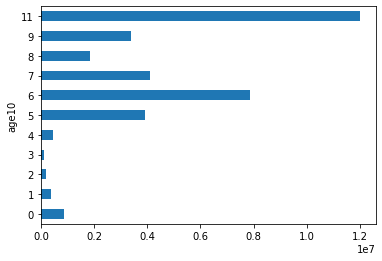

In [153]:
df.query('sample==1').groupby('age10').price.median().plot(kind='barh')

Видим разный тип распределения цены: машины в возрасте от 0 до 40 лет ровно дешевеют, машины в возрасте после 40 лет имеют скачкоообразное распределение - вероятно цена сильно зависит от состояния, и наконец мы видим, что машины с возрастом 60 лет (довольно интересный факт) и свыше 100 лет относятся к дорогим коллекционным авто.

In [154]:
# добавим признак ценности авто в зависимости от его возраста
df['retro'] = df['age10'].apply(lambda x: 1 if x > 3 else 0)

In [155]:
# избавимся от вспомогательного признака age10
df.drop(['age10'], axis=1, inplace=True)

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109540 entries, 0 to 109539
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   sell_id               109540 non-null  int64  
 1   bodyType              109540 non-null  object 
 2   brand                 109540 non-null  object 
 3   modelName             109540 non-null  object 
 4   color                 109540 non-null  object 
 5   fuelType              109540 non-null  object 
 6   modelDate             109540 non-null  int64  
 7   productionDate        109540 non-null  int64  
 8   mileage               109540 non-null  int64  
 9   engineDisplacement    109540 non-null  float64
 10  enginePower           109540 non-null  int64  
 11  numberOfDoors         109540 non-null  int64  
 12  vehicleTransmission   109540 non-null  object 
 13  vehicleConfiguration  109540 non-null  object 
 14  Привод                109540 non-null  object 
 15  

#### Структурируем признаки по типу данных

In [157]:
# текстовые поля, которые возможно пригодятся
txt_cols = ['vehicleConfiguration']

# бинарные переменные
bin_cols = ['ПТС', 'Руль', 'retro']

# категориальные переменные
cat_cols = ['bodyType', 'brand', 'modelName', 'color', 'fuelType', 
            'vehicleTransmission', 'Привод']

# числовые переменные
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 
            'numberOfDoors', 'productionDate', 'Владельцы','age']

#### Графики распределения числовых переменных

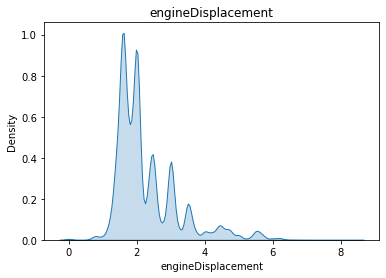

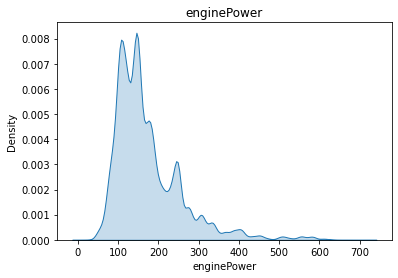

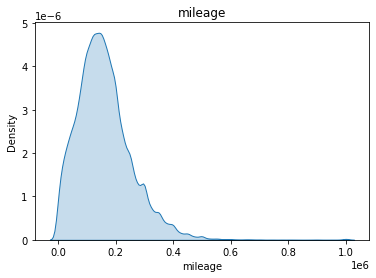

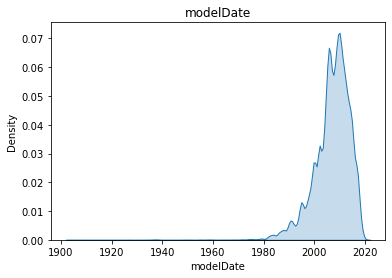

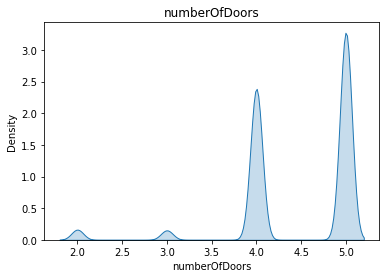

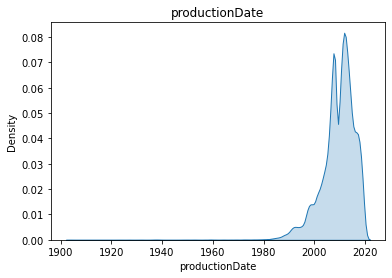

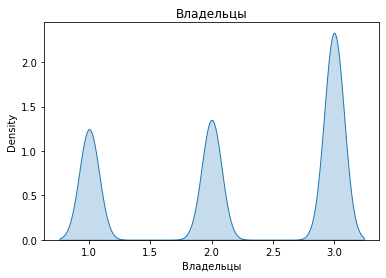

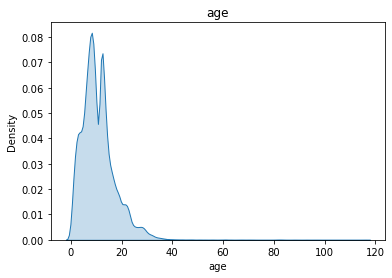

In [158]:
for i in num_cols:
    plt.figure()
    sns.kdeplot(df[i], shade=True)
    plt.title(i)
    plt.show()

Нормализуем данные с помощью логарифмирования

In [159]:
log_features = ['enginePower', 'mileage', 'modelDate', 'productionDate', 'age']
for i in [log_features]:
    df[i] = df[i].apply(lambda x: np.log((x)+1))

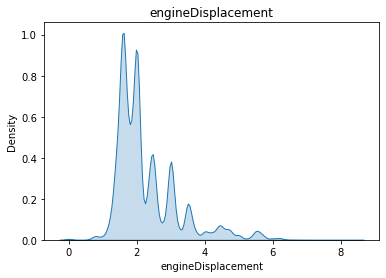

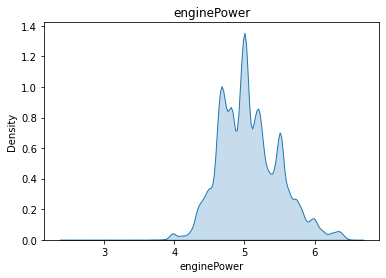

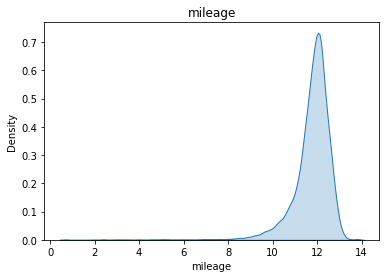

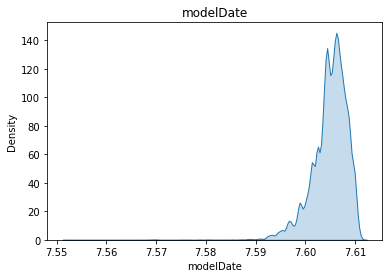

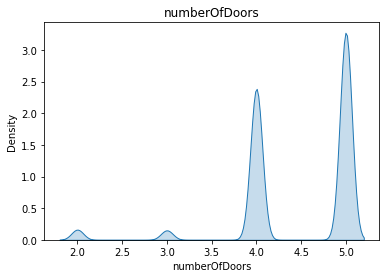

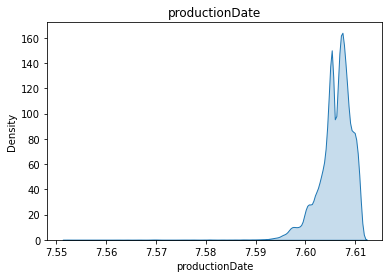

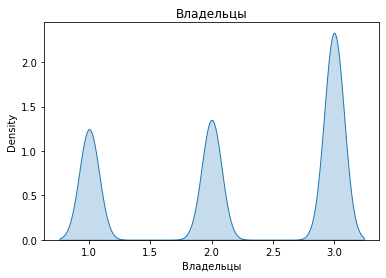

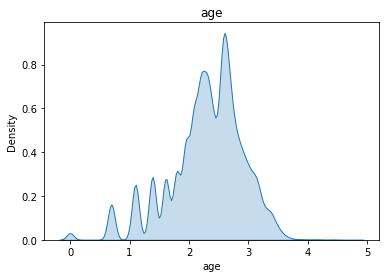

In [160]:
for i in num_cols:
    plt.figure()
    sns.kdeplot(df[i], shade=True)
    plt.title(i)
    plt.show()

#### Корреляция числовых признаков с таргетом

In [161]:
# посмотрим какие числовые признаки оказывают влияние на таргет
# вычисляем модуль корреляции
corr_with_target = df[df['sample'] == 1].corr()['price'].abs().sort_values()

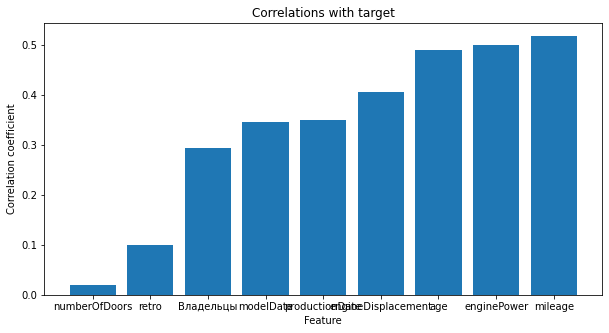

In [162]:
# удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('price')
# строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

1. Видим, что количество дверей (numberOfDoors) практически не влияет на таргет ---> удалим этот признак.

In [163]:
df.drop(['numberOfDoors'], axis=1, inplace=True)

1. Также удалим признак 'vehicleConfiguration', так как в нем содержится информация уже имеющаяся в других признаках.

In [164]:
df.drop(['vehicleConfiguration'], axis=1, inplace=True)

#### Готовим датасет для обучения

In [165]:
data = df.copy()

In [166]:
# разделим обратно общий датасет на тренировочный и тестовый по признаку sample
d_train = data.query('sample == 1').drop(['sample'], axis=1)
d_test = data.query('sample == 0').drop(['sample'], axis=1)

In [167]:
d_test.drop(columns=['price', 'sell_id'], inplace=True)

In [168]:
d_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             34686 non-null  object 
 1   brand                34686 non-null  object 
 2   modelName            34686 non-null  object 
 3   color                34686 non-null  object 
 4   fuelType             34686 non-null  object 
 5   modelDate            34686 non-null  float64
 6   productionDate       34686 non-null  float64
 7   mileage              34686 non-null  float64
 8   engineDisplacement   34686 non-null  float64
 9   enginePower          34686 non-null  float64
 10  vehicleTransmission  34686 non-null  object 
 11  Привод               34686 non-null  object 
 12  Руль                 34686 non-null  object 
 13  Владельцы            34686 non-null  int64  
 14  ПТС                  34686 non-null  object 
 15  age                  34686 non-null 

In [169]:
# удалим из тренировочного датасета признак sell_id - он нам не пригодится для обучения
d_train.drop(['sell_id'], axis=1, inplace=True)

In [170]:
# определяем признаки для Х (все, кромер целевого = price)
X = d_train.drop(columns=['price'])
y = d_train['price']

In [171]:
# разделим тренировочный датасет на учебную и валидационную части
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

### ML

### Наивная модель (медианное значение цены)

1. Прогноз цены на основе медианного значения признака mileage показал ошибку в 77%. Возьмем второй по значимости признак enginePower, сделаем предикт и измерим метрику.

In [172]:
naive_train = X_train.copy()
naive_train['price'] = y_train

In [173]:
y_pred = X_val['enginePower'].map(naive_train.groupby('enginePower')['price'].median())
print(f"Точность наивной модели по метрике MAPE: {(mape(y_val, y_pred.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 54.71%


Все равно получилась очень большая ошибка!

### CatBoostRegressor

1. Так как мы еще не перекодировали категориальные признаки, то хотим сразу проверить модель CatBoostRegressor

In [174]:
X_train.columns

Index(['bodyType', 'brand', 'modelName', 'color', 'fuelType', 'modelDate',
       'productionDate', 'mileage', 'engineDisplacement', 'enginePower',
       'vehicleTransmission', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'age',
       'retro'],
      dtype='object')

In [175]:
d_test.columns

Index(['bodyType', 'brand', 'modelName', 'color', 'fuelType', 'modelDate',
       'productionDate', 'mileage', 'engineDisplacement', 'enginePower',
       'vehicleTransmission', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'age',
       'retro'],
      dtype='object')

In [176]:
cat_features = ['bodyType', 'brand', 'modelName', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'Руль', 'ПТС']

In [177]:
# изменим тип данных в категориальных признаках на category
X_train[cat_features] = X_train[cat_features].astype('category')

In [178]:
d_test[cat_features] = d_test[cat_features].astype('category')

In [179]:
# model = CatBoostRegressor(cat_features = cat_features,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           depth = 10,
#                           iterations = 2000,
#                           learning_rate = 0.1,
#                           l2_leaf_reg = 0.2
#                          )

In [180]:
# model.fit(X_train, y_train,
#           eval_set=(X_val, y_val),
#           verbose_eval=0,
#           use_best_model=True,
#          #plot=True
#          )

In [181]:
# model.save_model('catboost_1.model')

In [182]:
# y_pred = model.predict(X_val)
# print(f"Точность модели по метрике MAPE: {(mape(y_val, y_pred))*100:0.2f}%")

1. Попробуем прологарифмировать таргет

In [183]:
# model = CatBoostRegressor(cat_features = cat_features,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           depth = 10,
#                           iterations = 2000,
#                           learning_rate = 0.1,
#                           l2_leaf_reg = 0.2
#                          )

# model.fit(X_train, np.log(y_train),
#           eval_set=(X_val, np.log(y_val)),
#           verbose_eval=0,
#           use_best_model=True,
#          #plot=True
#          )

In [184]:
# model.save_model('catboost_2.model')

In [185]:
# y_pred = np.exp(model.predict(X_val))
# print(f"Точность модели по метрике MAPE: {(mape(y_val, y_pred))*100:0.2f}%")

Получили метрику  = 13.47%

In [186]:
# делаем субмишен результат
# cat = CatBoostRegressor(cat_features = cat_features,
#                             random_seed = RANDOM_SEED,
#                             eval_metric='MAPE',
#                             depth = 10,
#                             iterations = 2000,
#                             learning_rate = 0.1,
#                             l2_leaf_reg = 0.2
#                            ).fit(X_train, np.log(y_train),
#                                  eval_set=(X_val, np.log(y_val)),
#                                  verbose_eval=0,
#                                  use_best_model=True,
#                                  #plot=True
#                                 )

In [187]:
# y_pred = np.exp(cat.predict(d_test))

In [188]:
# sample_submission['price'] = y_pred
# sample_submission.to_csv(f'submission_final.csv', index=False)
# sample_submission.head(10)

Сабмитим результат в ЛБ и получаем score = 12.53%

#### Перекодирование категориальных признаков

Для применения иных моделей нам потребуется перекодировать категориальные признаки в числовые

In [189]:
data1 = df.copy()

In [190]:
data.columns

Index(['sell_id', 'bodyType', 'brand', 'modelName', 'color', 'fuelType',
       'modelDate', 'productionDate', 'mileage', 'engineDisplacement',
       'enginePower', 'vehicleTransmission', 'Привод', 'Руль', 'Владельцы',
       'ПТС', 'price', 'sample', 'age', 'retro'],
      dtype='object')

In [191]:
cat_cols = ['bodyType', 'brand', 'modelName', 'color', 'fuelType', 'vehicleTransmission', 'Привод']
bin_cols = ['Руль', 'ПТС']

Для бинарных признаков используем label encoding

In [192]:
for colum in bin_cols:
    data[colum] = data[colum].astype('category').cat.codes

Для категориальных признаков c небольшим количеством уникальных значений также будем использовать label encoding

In [193]:
for colum in ['fuelType', 'vehicleTransmission', 'Привод']:
    data[colum] = data[colum].astype('category').cat.codes

Для категориальных признаков c большим количеством уникальных значений также будем использовать Binary encoding

In [194]:
# создаем объект для перекодировки
encoder= ce.BinaryEncoder(cols=['bodyType', 'brand', 'modelName', 'color'], return_df=True)

In [195]:
# применяем Fit and Transform ко всему датасету
data_encoded=encoder.fit_transform(data) 
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109540 entries, 0 to 109539
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sell_id              109540 non-null  int64  
 1   bodyType_0           109540 non-null  int64  
 2   bodyType_1           109540 non-null  int64  
 3   bodyType_2           109540 non-null  int64  
 4   bodyType_3           109540 non-null  int64  
 5   bodyType_4           109540 non-null  int64  
 6   brand_0              109540 non-null  int64  
 7   brand_1              109540 non-null  int64  
 8   brand_2              109540 non-null  int64  
 9   brand_3              109540 non-null  int64  
 10  brand_4              109540 non-null  int64  
 11  brand_5              109540 non-null  int64  
 12  modelName_0          109540 non-null  int64  
 13  modelName_1          109540 non-null  int64  
 14  modelName_2          109540 non-null  int64  
 15  modelName_3      

Вновь подготовим общий датасет для последующего обучения

In [196]:
# разделим обратно общий датасет на тренировочный и тестовый по признаку sample
d_train_1 = data_encoded.query('sample == 1').drop(['sample', 'sell_id'], axis=1)
d_test_1 = data_encoded.query('sample == 0').drop(['sample', 'sell_id', 'price'], axis=1)

In [197]:
# определяем признаки для Х (все, кромер целевого = price)
X_1 = d_train_1.drop(columns=['price'])
y_1 = d_train_1['price']

In [198]:
# разделим тренировочный датасет на учебную и валидационную части
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_1, y_1, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

### RandomForestRegressor

1. Применяем без логарифмирования таргета

In [199]:
# rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# rf.fit(X_train_1, y_train_1)
# y_pred_rf = rf.predict(X_val_1)

# print(f"Точность модели Random Forest по метрике MAPE: {(mape(y_val_1, y_pred_rf))*100:0.2f}%")

Получили ужасный результат MAPE = 16.52%

2. Пробуем с логарифмированием таргета

In [200]:
# rf_log = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# rf_log.fit(X_train_1, np.log(y_train_1))
# y_pred_rf_log = np.exp(rf_log.predict(X_val_1))

# print(f"Точность модели Random Forest по метрике MAPE: {(mape(y_val_1, y_pred_rf_log))*100:0.2f}%")

Видим улучшение метрики = 14.47%

3. Пробуем сабмит в ЛБ

In [201]:
# y_pred_rf_log = np.exp(rf_log.predict(d_test_1))

In [202]:
# sample_submission['price'] = y_pred_rf_log
# sample_submission.to_csv(f'submission_rf.csv', index=False)
# sample_submission.head(10)

Сабмитим результат в ЛБ и получаем score = 11.90%

### Extremely Randomized Trees (ExtraTreesRegressor)

1. Можно сделать однозначный вывод, что лучшую метрику показывет применение логарифмирования к таргету, так как оно нормализует распределение.

In [203]:
etr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
etr_log.fit(X_train_1, np.log(y_train_1))
y_pred_etr_log = np.exp(etr_log.predict(X_val_1))

print(f"Точность модели Extra Trees по метрике MAPE: {(mape(y_val_1, y_pred_etr_log))*100:0.2f}%")

Получили метрику = 14.91% что не является лучшим результатом.

2. Сделаем визуализацию наиболее важных признаков

In [204]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(etr_log.feature_importances_, index=X_1.columns)
feat_importances.nlargest(15).plot(kind='barh')

В целом вполне предсказуемо, наиболее важными являются возраст и мощность машины.

3. Сделаем сабмит в ЛБ

In [205]:
y_pred_etr_log = np.exp(etr_log.predict(d_test_1))

In [217]:
sample_submission['price'] = y_pred_etr_log
sample_submission.to_csv(f'submission_etr.csv', index=False)
sample_submission.head(10)

NameError: name 'y_pred_etr_log' is not defined

Улучшили свой score до 10.82%

### StackingRegressor v1

RandomForestRegressor + ExtraTreesRegressor = LinearRegression

In [213]:
# estimators = [
#     ('rf', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
#     ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1))
# ]

# sr_log = StackingRegressor(
#     estimators=estimators,
#     final_estimator=LinearRegression()
# )

# sr_log.fit(X_train_1, np.log(y_train_1))
# y_pred_sr_log = np.exp(sr_log.predict(X_val_1))

# print(f"Точность модели StackingRegressor по метрике MAPE: {(mape(y_val_1, y_pred_sr_log))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: D

Точность модели StackingRegressor по метрике MAPE: 14.27%


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Получили не самую лучшую метрику = 14.27%

Сделаем сабмит

In [214]:
# y_pred_sr_log = np.exp(sr_log.predict(d_test_1))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [216]:
# sample_submission['price'] = y_pred_sr_log
# sample_submission.to_csv(f'submission_sr.csv', index=False)
# sample_submission.head(10)

,sell_id,price
0,1100575026,5.795243e+05
1,1100549428,9.003736e+05
2,1100658222,8.408341e+05
3,1100937408,6.757317e+05
4,1101037972,6.439604e+05
5,1100912634,7.109264e+05
6,1101228730,5.867810e+05
7,1100165896,3.757576e+05
8,1100768262,1.820720e+06
9,1101218501,6.715424e+05


Score на платформе ухудшился до 11.1%

### StackingRegressor v2

CatBoostRegressor (но на перекодированных категориальных данных) + ExtraTreesRegressor = LinearRegression

In [220]:
# estimators = [
#     ('cat', CatBoostRegressor(random_seed = RANDOM_SEED, eval_metric='MAPE',
#                               depth = 10, iterations = 2000, learning_rate = 0.1, l2_leaf_reg = 0.2)),
#     ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1))
# ]

# sr_log_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# sr_log_1.fit(X_train_1, np.log(y_train_1))
# y_pred_sr_log_1 = np.exp(sr_log_1.predict(X_val_1))

# print(f"Точность модели StackingRegressor по метрике MAPE: {(mape(y_val_1, y_pred_sr_log_1))*100:0.2f}%")

0:	learn: 0.0485154	total: 86ms	remaining: 2m 52s
1:	learn: 0.0444764	total: 107ms	remaining: 1m 46s
2:	learn: 0.0409267	total: 127ms	remaining: 1m 24s
3:	learn: 0.0377284	total: 146ms	remaining: 1m 12s
4:	learn: 0.0348986	total: 162ms	remaining: 1m 4s
5:	learn: 0.0323277	total: 178ms	remaining: 59.2s
6:	learn: 0.0300503	total: 195ms	remaining: 55.4s
7:	learn: 0.0280359	total: 211ms	remaining: 52.7s
8:	learn: 0.0262544	total: 227ms	remaining: 50.3s
9:	learn: 0.0247346	total: 244ms	remaining: 48.6s
10:	learn: 0.0233619	total: 260ms	remaining: 46.9s
11:	learn: 0.0222135	total: 274ms	remaining: 45.4s
12:	learn: 0.0211792	total: 291ms	remaining: 44.5s
13:	learn: 0.0202081	total: 310ms	remaining: 43.9s
14:	learn: 0.0192534	total: 329ms	remaining: 43.6s
15:	learn: 0.0185806	total: 349ms	remaining: 43.3s
16:	learn: 0.0179234	total: 369ms	remaining: 43.1s
17:	learn: 0.0173599	total: 389ms	remaining: 42.9s
18:	learn: 0.0167942	total: 405ms	remaining: 42.2s
19:	learn: 0.0162080	total: 420ms	rema

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s finished


0:	learn: 0.0485705	total: 17.1ms	remaining: 34.2s
1:	learn: 0.0446420	total: 31ms	remaining: 31s
2:	learn: 0.0410958	total: 47.1ms	remaining: 31.4s
3:	learn: 0.0378480	total: 62.2ms	remaining: 31s
4:	learn: 0.0350329	total: 76.4ms	remaining: 30.5s
5:	learn: 0.0324508	total: 91.1ms	remaining: 30.3s
6:	learn: 0.0301389	total: 105ms	remaining: 30s
7:	learn: 0.0281362	total: 119ms	remaining: 29.7s
8:	learn: 0.0263223	total: 135ms	remaining: 29.9s
9:	learn: 0.0247598	total: 149ms	remaining: 29.6s
10:	learn: 0.0233617	total: 164ms	remaining: 29.7s
11:	learn: 0.0221836	total: 180ms	remaining: 29.9s
12:	learn: 0.0211788	total: 195ms	remaining: 29.8s
13:	learn: 0.0202099	total: 208ms	remaining: 29.5s
14:	learn: 0.0193166	total: 222ms	remaining: 29.4s
15:	learn: 0.0185970	total: 236ms	remaining: 29.3s
16:	learn: 0.0179720	total: 250ms	remaining: 29.2s
17:	learn: 0.0174339	total: 264ms	remaining: 29.1s
18:	learn: 0.0169701	total: 278ms	remaining: 29s
19:	learn: 0.0163654	total: 292ms	remaining: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]:

Точность модели StackingRegressor по метрике MAPE: 13.68%


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Результат по метрике удручающий = 13.68%
Попробуем сделать сабмит на платформе.

In [223]:
# y_pred_sr_log_1 = np.exp(sr_log_1.predict(d_test_1))

In [222]:
# sample_submission['price'] = y_pred_sr_log
# sample_submission.to_csv(f'submission_sr_log_1.csv', index=False)
# sample_submission.head(10)

,sell_id,price
0,1100575026,5.795243e+05
1,1100549428,9.003736e+05
2,1100658222,8.408341e+05
3,1100937408,6.757317e+05
4,1101037972,6.439604e+05
5,1100912634,7.109264e+05
6,1101228730,5.867810e+05
7,1100165896,3.757576e+05
8,1100768262,1.820720e+06
9,1101218501,6.715424e+05


Результат на платформе практически равен результату использования модели StackingRegressor v1

### ВЫВОД:

 наилучший score на платформе получен при использовании Extremely Randomized Trees (ExtraTreesRegressor)